In [1]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import pofah.jet_sample as js
import pofah.phase_space.cut_constants as cuts
import dadrah.kfold_pipeline.kfold_string_constants as kstco
import dadrah.selection.selection_util as seut
import dadrah.kfold_pipeline.kfold_util as kutil

import pathlib
import argparse
from typing import List

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
from typing import List
from recordtype import recordtype

Welcome to JupyROOT 6.22/00


## run config

In [25]:
Parameters = recordtype('Parameters','qr_run_n, quantiles, qcd_sample_id, sig_sample_id, sig_xsec, score_strategy_id, read_n, env_run_n, poly_run_n')
params = Parameters(qr_run_n=412,
                    quantiles=[0.3, 0.5, 0.7, 0.9],
                    qcd_sample_id='qcdSigAll', 
                    sig_sample_id='GtoWW35naReco',
                    sig_xsec=0,
                    score_strategy_id='rk5_05',
                    read_n=None,
                    env_run_n=1,
                    poly_run_n=0,
                    )

qr_model_str, train_share = '_'.join(['kfold',str(params.qr_run_n),str(params.env_run_n),str(params.poly_run_n)]), 0

xsec = 0
xsecs_sig   = [0,20,40,60,80,100] # signal cross sections
mX = 3.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]
#quantiles = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
#quantiles = [0.3, 0.5, 0.7, 0.9]
#quantiles = [0.5, 0.9]

train_frac=0 # all data used in inference

# choose which template quantile to use (0 = 0.9-1.0, 1 = 0.7-0.9)
template_q_idx = 0

# paths
input_path = kstco.get_polynomials_out_data_dir(params)
fig_dir = 'fig/qr_run_'+str(int(params.qr_run_n))+'/env_run_'+str(int(params.env_run_n))+'/poly_run_'+str(int(params.poly_run_n))
pathlib.Path(fig_dir).mkdir(parents=True, exist_ok=True)

In [26]:
# Rescaling the inputs to lumi
xsec_qcd       = 8730000.0 # Crossection in fb             
qcd_gen_events = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
xsec_sig_default = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events = 982038.0 #(all generated signal)
lumi           = qcd_gen_events/xsec_qcd # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = xsec_qcd*lumi/qcd_gen_events
scale_sig = (1-train_frac)*xsec_sig_default*lumi/sig_gen_events #20% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale {} QCD events with {}'.format(qcd_gen_events,scale_qcd))
print('Scale {} signal events with {} for 10fb default sig xsec'.format(sig_gen_events,scale_sig))

Usign luminosity 63.98123745704467
Scale 558556203.0 QCD events with 1.0
Scale 982038.0 signal events with 0.0006515148849336245 for 10fb default sig xsec


# read in data

### train xsec = 0 !

In [27]:
samples = {}

for sample_id in sample_ids:
    in_path = os.path.join(input_path,sample_id+'.h5') #paths.in_file_path(sample_id)
    samples[sample_id] = js.JetSample.from_input_file(sample_id, in_path)
    print('read ' + str(len(samples[sample_id])) + ' ' + sample_id + ' samples from ' + in_path)

read 11985958 qcdSigAll samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_412/env_run_1/poly_run_0/qcdSigAll.h5
read 531825 GtoWW35naReco samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_412/env_run_1/poly_run_0/GtoWW35naReco.h5


### divide into orthogonal quantiles

In [28]:
# qcd
samples_ortho_quantiles_qcd = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], params.quantiles)
mjj_vals_qcd = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_qcd]
# signal
samples_ortho_quantiles_sig = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_sig], params.quantiles)
mjj_vals_sig = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_sig]

In [29]:
num_samples_qcd = sum(map(len,mjj_vals_qcd))
print(num_samples_qcd)
num_samples_sig = sum(map(len,mjj_vals_sig))
print(num_samples_sig)

11985965
531829


In [30]:
quantiles_inv = [round((1.-q),2) for q in [0]+params.quantiles] # invert quantiles to [1.0 0.9, 0.7, 0.5, 0.3, 0.1, 0.01]
q_str_leg = [str(q) for q in quantiles_inv+[0.]]

In [31]:
q_str_leg

['1.0', '0.7', '0.5', '0.3', '0.1', '0.0']

In [34]:
min_mjj = 1200.
max_mjj = 6000. #5600
bin_edges = kutil.get_bins_from_envelope(params)
bin_edges = bin_edges[(bin_edges>=min_mjj) & (bin_edges<=max_mjj)]

print('min_mjj='+str(min_mjj) + ', max_mjj='+str(max_mjj))
print('bin edges')
print(bin_edges)

n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

min_mjj=1200.0, max_mjj=6000.0
bin edges
[1209.00882972 1227.20940799 1245.77860949 1264.72204299 1284.04539317
 1303.75442158 1323.85496757 1344.35294932 1365.25436481 1386.56529285
 1408.29189411 1430.44041211 1453.01717433 1476.02859322 1499.4811673
 1523.38148223 1547.73621194 1572.55211971 1597.8360593  1623.59497612
 1649.83590834 1676.56598811 1703.79244269 1731.52259567 1759.7638682
 1788.52378018 1817.80995153 1847.63010343 1877.99205958 1908.90374751
 1940.37319988 1972.40855578 2005.01806207 2038.21007474 2071.99306026
 2106.37559696 2141.36637646 2176.97420506 2213.20800515 2250.07681673
 2287.58979879 2325.75623087 2364.58551452 2404.08717484 2444.27086201
 2485.14635284 2526.72355238 2569.01249547 2612.02334841 2655.76641052
 2700.25211587 2745.49103492 2791.49387619 2838.27148802 2885.83486028
 2934.19512612 2983.36356377 3033.35159831 3084.17080351 3135.83290368
 3188.34977548 3241.73344988 3295.99611403 3351.15011316 3407.20795261
 3464.18229974 3522.08598597 3580.9320

In [35]:
n_bins

98

### color palettes

In [36]:
cmap_qcd = cm.get_cmap('winter') # 'summer'
cmap_qcd = [mpl.colors.rgb2hex(c) for c in cmap_qcd(np.linspace(0.0, 1.0, len(mjj_vals_qcd)+1))][1:]
cmap_sig = cm.get_cmap('winter')
cmap_sig = [mpl.colors.rgb2hex(c) for c in cmap_sig(np.linspace(0.0, 1.0, len(mjj_vals_sig)+1))][1:]
bump_col = '#e25650' # colors for signal bump

## fill events into histograms

In [45]:
n_bins = len(bin_edges)-1 #50
hist_sz = 700
marker_sty = 8
marker_sz = 0.75

In [46]:
datas_qcd = {}
datas_sig = {}

# qcd template / bottom histogram
props={'LineColor': rt.kBlack, "YTitle": 'num events', "XTitle": "M_{jj} [GeV]", "Title":"", "Minimum": 0.2, "Maximum": num_samples_qcd*1.1}
datas_qcd[quantiles_inv[template_q_idx]] = rpu.create_hist(mjj_vals_qcd[template_q_idx],'',n_bins, bin_edges.astype('float'), props=props)

# qcd other ortho quantile hists
for mjj, q, c in zip(mjj_vals_qcd[template_q_idx+1:], quantiles_inv[template_q_idx+1:], cmap_qcd[template_q_idx:]):
    props = {"LineColor": rt.TColor.GetColor(c), "MarkerColor": rt.TColor.GetColor(c), "LineWidth": 1, "MarkerStyle": marker_sty, "MarkerSize": marker_sz}
    datas_qcd[q] = rpu.create_hist(mjj, '', n_bins, bin_edges.astype('float'), props=props)

# signal orthogonal quantiles
for mjj, q, in zip(mjj_vals_sig[template_q_idx:], quantiles_inv[template_q_idx:]):
    props = {"LineColor": rt.TColor.GetColor(bump_col), "LineColorAlpha": ((rt.TColor.GetColor(bump_col)), q), "FillColorAlpha": ((rt.TColor.GetColor(bump_col)), q*0.8), "LineWidth": 1,}
    datas_sig[q] = rpu.create_hist(mjj, '', n_bins, bin_edges.astype('float'), props=props)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


## make histograms with injected signal pseudo data

In [47]:
# this is all for training signal xsec = 0

histos_data_inj = {}
histos_sig_inj = {}

# for each quantile
for q in quantiles_inv[template_q_idx:]:

    q_str = 'q'+str(int(q*100))
    # treat special case when bottom q is bounded on the left: in gof name is hardcoded to q100, so change the name
    if template_q_idx == 1 and q == 0.9: q_str = 'q'+str(100)

    histos_data_inj_quantile = {}
    histos_sig_inj_quantile = {}
    
    # for each signal cross section (each signal injection value)
    for xsec in xsecs_sig:
        
        sig_inj = int(xsec/10)
        print('xsec {}, sig_inj {}'.format(xsec, sig_inj))
        hist_data_xsec = datas_qcd[q].Clone('data_hist_acc_inj{}_{}'.format(sig_inj,q_str)) # get qcd events for quantile q
        hist_sig_xsec = datas_sig[q].Clone('signal_inj{}_{}'.format(sig_inj,q_str)) # get signal events for quantile q
        tmpSig = hist_sig_xsec.Clone('tmp_signal_inj{}_{}'.format(sig_inj,q_str))
        print("Data before injection = {}".format(hist_data_xsec.Integral()))
        
        # Scale signal by the crossection injected (default is 10 fb)
        print("Signal before scaling = {}".format(tmpSig.Integral()))
        tmpSig.Scale(scale_sig*sig_inj if sig_inj != 0 else scale_sig)
        print("Signal after scaling = {}".format(tmpSig.Integral()))
        
        hist_data_xsec.Sumw2() # Sumw2: tell the histogram class to also store errors.
        tmpSig.Sumw2()
        hist_sig_xsec.Sumw2()
        
        rdm = rt.TRandom3(0)
        for i in range (0,tmpSig.GetNbinsX()):
            n = tmpSig.GetBinContent(i+1)  
            n_rdm = rdm.Poisson(n)
            hist_sig_xsec.SetBinContent(i+1,n_rdm)
            hist_sig_xsec.SetBinError(i+1,n_rdm**0.5)
        print("Signal after pseudodata = {}".format(hist_sig_xsec.Integral()))
    
        # add pseudo signal events to qcd events. 
        if sig_inj != 0:
            hist_data_xsec.Add(hist_sig_xsec)
            
        print("Data after injection = {}".format(hist_data_xsec.Integral()))

        hist_data_xsec.SetBinErrorOption(rt.TH1.kPoisson)
        
        # save mixed data histo and signal histo in quantile dict
        histos_data_inj_quantile[sig_inj] = hist_data_xsec
        histos_sig_inj_quantile[sig_inj] = hist_sig_xsec
        
    # save full xsec set for each quantile
    histos_data_inj[q] = histos_data_inj_quantile
    histos_sig_inj[q] = histos_sig_inj_quantile


xsec 0, sig_inj 0
Data before injection = 3456612.0
Signal before scaling = 69126.0
Signal after scaling = 45.036617935921726
Signal after pseudodata = 61.0
Data after injection = 3456612.0
xsec 20, sig_inj 2
Data before injection = 3456612.0
Signal before scaling = 69126.0
Signal after scaling = 90.07323587184345
Signal after pseudodata = 74.0
Data after injection = 3456686.0
xsec 40, sig_inj 4
Data before injection = 3456612.0
Signal before scaling = 69126.0
Signal after scaling = 180.1464717436869
Signal after pseudodata = 181.0
Data after injection = 3456793.0
xsec 60, sig_inj 6
Data before injection = 3456612.0
Signal before scaling = 69126.0
Signal after scaling = 270.2197076155304
Signal after pseudodata = 278.0
Data after injection = 3456890.0
xsec 80, sig_inj 8
Data before injection = 3456612.0
Signal before scaling = 69126.0
Signal after scaling = 360.2929434873738
Signal after pseudodata = 365.0
Data after injection = 3456977.0
xsec 100, sig_inj 10
Data before injection = 34

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure al

# plot ratio hist for each quantile with increasing xsec added

In [48]:
template_q = quantiles_inv[template_q_idx]
sig_injs = [int(xsec/10) for xsec in xsecs_sig]
sig_inj = sig_injs[-1]

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: pdf file fig/mjj_ratio_inj_sig_xsec_0_qr_run412.pdf has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: pdf file fig/mjj_ratio_inj_sig_xsec_20_qr_run412.pdf has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum

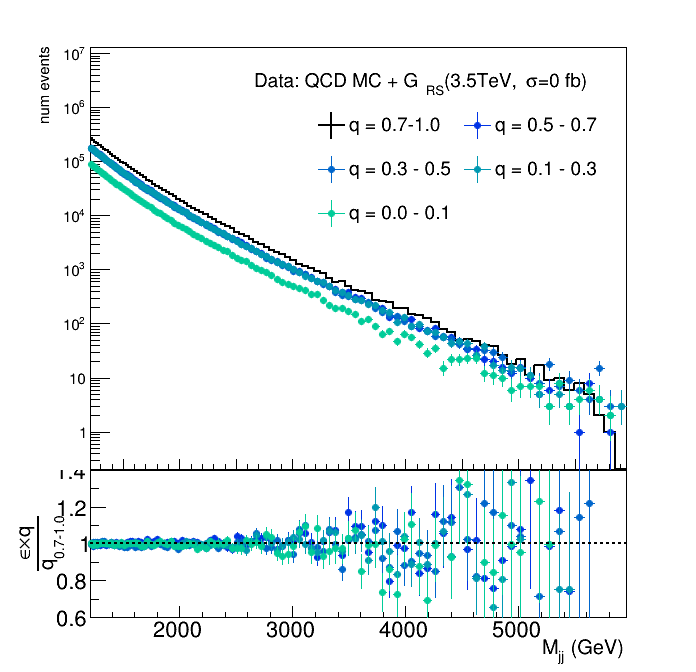

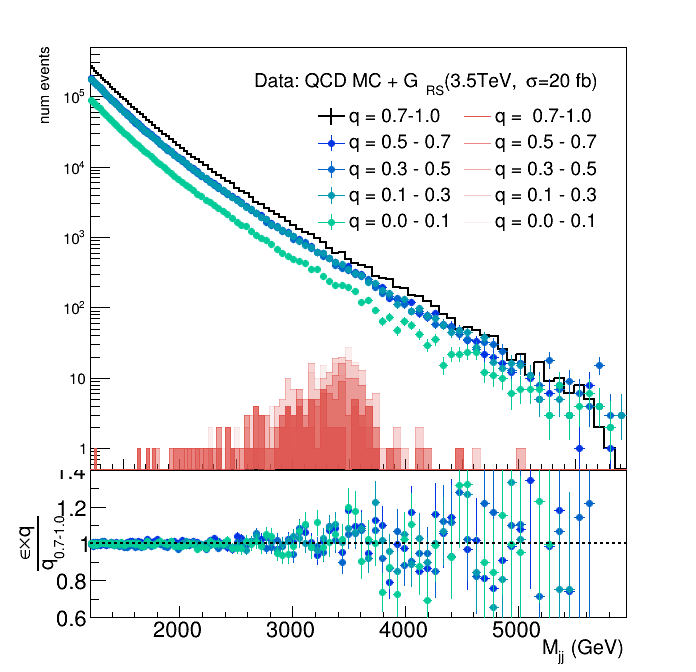

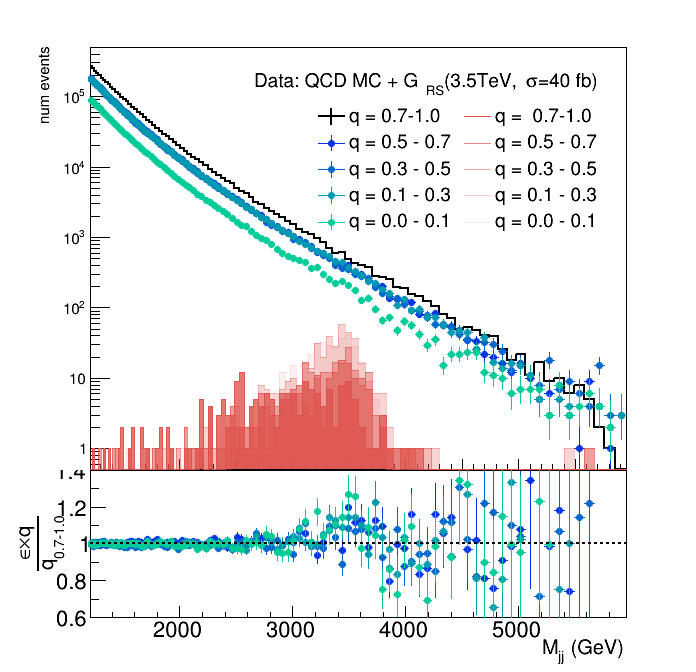

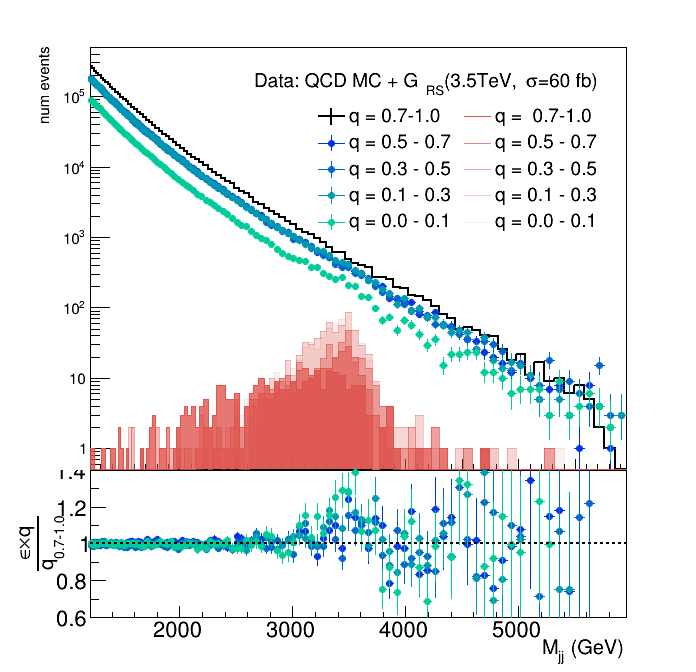

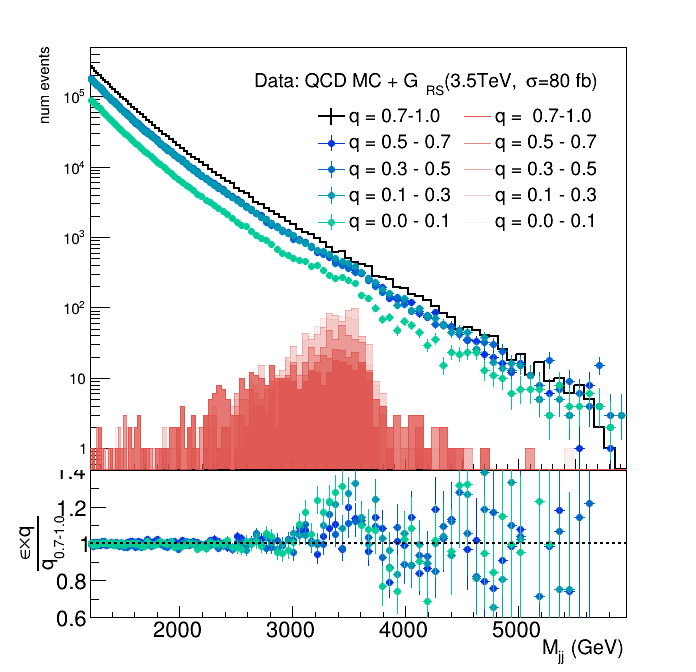

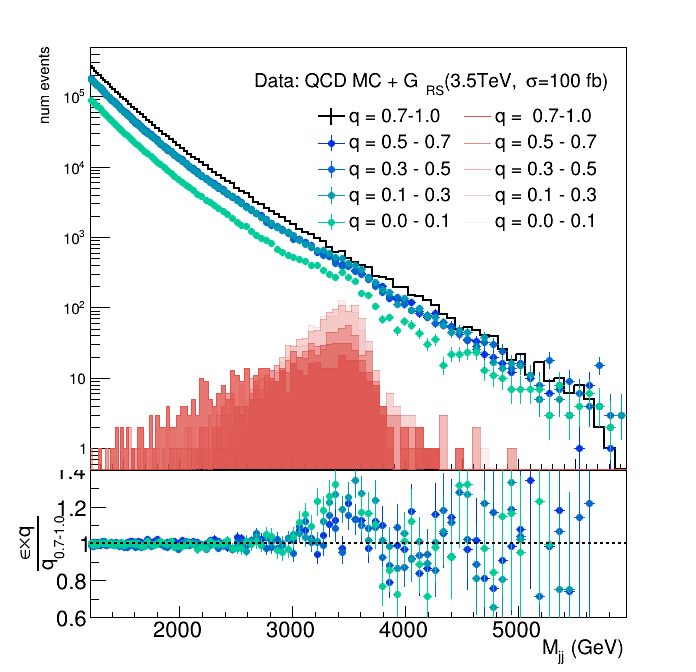

In [49]:
import cmsstyle #mplhep for Python2 cheatsheet

# for each signal injection value
for sig_inj in sig_injs:

    c_out, pad1, pad2 = rpu.create_canvas_pads(pad_props={'LeftMargin': 0.13})
    
    # legend
    leg = rpu.create_object("TLegend", 0.45, 0.5, 0.87, 0.78)
    leg.SetNColumns(2)
    leg_h = rpu.create_object("TLegend", 0.35, 0.8, 0.95, 0.85) # second legend for header because left align not available
    rpu.set_style(leg,props={'TextSize': 0.045})
    rpu.set_style(leg_h,props={'TextSize': 0.045})

    ### plot data histograms

    pad1.cd()

    # draw template bottom quantile data and signal histogram
    ht = histos_data_inj[template_q][sig_inj] 
    ht.Draw('HIST')
    leg.AddEntry(ht, 'q = '+q_str_leg[template_q_idx+1]+'-'+q_str_leg[template_q_idx], 'lep')
    # sig_inj histo at xsec 0 can not be empyt, so filled with 10fb, so have to guard plotting each time :|
    if sig_inj != 0:
        hs = histos_sig_inj[template_q][sig_inj]
        hs.Draw('hist same')
        leg.AddEntry(hs, 'q =  '+q_str_leg[template_q_idx+1]+'-'+q_str_leg[template_q_idx], 'l')


    # draw all other quantile histograms
    for q, q_str_i, q_str_ii in zip(quantiles_inv[template_q_idx+1:], q_str_leg[template_q_idx+2:], q_str_leg[template_q_idx+1:]):
        # data
        h = histos_data_inj[q][sig_inj]
        h.Draw('same')
        leg.AddEntry(h, 'q = {} - {}'.format(q_str_i,q_str_ii), 'lep')
        # signal
        if sig_inj != 0:
            hs = histos_sig_inj[q][sig_inj]
            hs.Draw('hist same')
            leg.AddEntry(hs, 'q = {} - {}'.format(q_str_i,q_str_ii), 'l')

    leg_h.SetHeader(r'Data: QCD MC + G_{RS}(%.1fTeV, #sigma=%i fb)'%(mX,sig_inj*10))
    leg.Draw()
    leg_h.Draw()

    # create ratio histograms
    hr = []
    for q, c in zip(quantiles_inv[template_q_idx+1:], cmap_qcd):
        h = histos_data_inj[q][sig_inj]
        props={"LineColor": rt.TColor.GetColor(c), "MarkerColor": rt.TColor.GetColor(c), "Title": '', "LineWidth": 1, "MarkerStyle": marker_sty}
        r = rpu.create_ratio_hist(h,histos_data_inj[template_q][sig_inj],props=props)
        hr.append(r)
    rpu.set_style(hr[0], props={ "XTitle": 'M_{jj} [GeV]', "YTitle": "ratio SIG / BG"})

    pad2.cd()
    hr[0].Draw('pe')
    props={'YTitle':'#frac{#epsilon#timesq}{q_{'+q_str_leg[template_q_idx+1]+'-'+q_str_leg[template_q_idx]+'}}', 'XTitle':'M_{jj} (GeV)', 'Maximum':1.4, 'Minimum':0.6, 'TitleOffset':0.2}
    rpu.set_style(hr[0],props=props)
    rpu.set_style(hr[0].GetYaxis(),props={'TitleSize':0.11, 'LabelSize':0.12, 'Ndivisions':304, 'TitleOffset':0.4 })
    rpu.set_style(hr[0].GetXaxis(),props={'TitleSize':0.11, 'LabelSize':0.12, 'Ndivisions':304, 'TitleOffset':0.95, 'Ndivisions':909, 'TickSize':0.07 })
    hr[0].GetYaxis().CenterTitle()

    for r in hr[1:]:
        r.Draw('pe same')

    eff_line = rpu.create_ratio_line(hr[0])
    eff_line.Draw('same')

    c_out.Draw()
    c_out.SaveAs('fig/mjj_ratio_inj_sig_xsec_{}_qr_run{}.pdf'.format(sig_inj*10, params.qr_run_n))

In [50]:
for inj in sig_injs:
    
    sum_sig_inj = sum(histos_sig_inj[q][inj].Integral() for q in quantiles_inv[template_q_idx:])
    sum_data = sum(histos_data_inj[q][inj].Integral() for q in quantiles_inv[template_q_idx:])

    for q in quantiles_inv[template_q_idx:]:
        print('sig inj {}, q {}: {} signal events'.format(inj, q, histos_sig_inj[q][inj].Integral()))

    print('total injected sig events for xsec {}: {} ({:.4f}% of {} data events)'.format(inj*10, sum_sig_inj, (sum_sig_inj/sum_data)*100, sum_data))


sig inj 0, q 1.0: 61.0 signal events
sig inj 0, q 0.7: 57.0 signal events
sig inj 0, q 0.5: 49.0 signal events
sig inj 0, q 0.3: 87.0 signal events
sig inj 0, q 0.1: 99.0 signal events
total injected sig events for xsec 0: 353.0 (0.0031% of 11516799.0 data events)
sig inj 2, q 1.0: 74.0 signal events
sig inj 2, q 0.7: 84.0 signal events
sig inj 2, q 0.5: 108.0 signal events
sig inj 2, q 0.3: 200.0 signal events
sig inj 2, q 0.1: 167.0 signal events
total injected sig events for xsec 20: 633.0 (0.0055% of 11517432.0 data events)
sig inj 4, q 1.0: 181.0 signal events
sig inj 4, q 0.7: 182.0 signal events
sig inj 4, q 0.5: 216.0 signal events
sig inj 4, q 0.3: 409.0 signal events
sig inj 4, q 0.1: 378.0 signal events
total injected sig events for xsec 40: 1366.0 (0.0119% of 11518165.0 data events)
sig inj 6, q 1.0: 278.0 signal events
sig inj 6, q 0.7: 286.0 signal events
sig inj 6, q 0.5: 358.0 signal events
sig inj 6, q 0.3: 637.0 signal events
sig inj 6, q 0.1: 573.0 signal events
tota

## write out histogram files

In [51]:
quantiles_inv

[1.0, 0.7, 0.5, 0.3, 0.1]

In [44]:
# Make one file for shortcut-data
tag = 'PDinj_NA3p5'

sig_injs = [0,2,4,6,8,10]

outfile = rt.TFile("histograms_injSig_{}.root".format(tag), 'RECREATE' )

for si in sig_injs:
    xs = 10*si    
    for q in quantiles_inv[template_q_idx:]:
        quantile = int(q*100)
        # treat special case when bottom q is bounded on the left: in gof name is hardcoded to q100, so change the name
        if template_q_idx == 1 and q == 0.9: quantile = 100
        print("For xsec {}, q {}".format(xs,quantile))
        histos_data_inj[q][si].Write('data_acc_{}fb_q{}p'.format(xs,quantile))
        histos_sig_inj[q][si].Write('signal_acc_{}fb_q{}p'.format(xs,quantile))

outfile.Close() 

For xsec 0, q 100
For xsec 0, q 70
For xsec 0, q 50
For xsec 0, q 30
For xsec 0, q 10
For xsec 20, q 100
For xsec 20, q 70
For xsec 20, q 50
For xsec 20, q 30
For xsec 20, q 10
For xsec 40, q 100
For xsec 40, q 70
For xsec 40, q 50
For xsec 40, q 30
For xsec 40, q 10
For xsec 60, q 100
For xsec 60, q 70
For xsec 60, q 50
For xsec 60, q 30
For xsec 60, q 10
For xsec 80, q 100
For xsec 80, q 70
For xsec 80, q 50
For xsec 80, q 30
For xsec 80, q 10
For xsec 100, q 100
For xsec 100, q 70
For xsec 100, q 50
For xsec 100, q 30
For xsec 100, q 10
